# Determining Concentration Profiles from the IEQ Dataset
Using some novel methods to understand the concentration profiles as measured by the BEVO Beacons.

In [38]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from src.visualization import visualize
from src.features.principal_component_analysis import pca
from src.features.feature_engineering import fe

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, ListedColormap, LinearSegmentedColormap

import seaborn as sns

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 200)
import scipy
import math

from datetime import datetime, timedelta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Import
We want all the measurements made by the beacon - not just the nightly concentrations.

In [2]:
data = pd.read_csv("../data/processed/beacon-ux_s20.csv", parse_dates=["timestamp"],index_col="timestamp",infer_datetime_format=True)
# dropping the unecessary id columns
data.drop(["beiwe","fitbit","redcap","no2"],axis="columns",inplace=True)

# Helper Functions
Some helpful functions that we will probably call from time to time.

In [4]:
def scale_data(df):
    """scales the data in each column between 0 and 1 based on min-max"""
    scaler = MinMaxScaler()
    for col in df.columns:
        try:
            df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
        except ValueError:
            pass
        
    return df

In [5]:
def get_beacon(df,bb):
    """gets data specific to the given beacon"""
    return df[df["beacon"] == bb]

In [6]:
def get_timing(s_time,e_time):
    """gets the seconds between the two time periods"""
    return round((e_time - s_time).total_seconds(),1)

In [7]:
def resample_data(df,minutes):
    """resamples the data to the given frequency"""
    if isinstance(df.index,pd.DatetimeIndex):
        return df.resample(f"{minutes}T").mean()
    else:
        try:
            df.set_index("timestamp",inplace=True)
            return df.resample(f"{minutes}T").mean()
        except KeyError:
            print("Need to set index as datetime")
            return df

# Table and Heatmap Generation
Creating some tables/heatmaps to visualize the data and pre-process it.

In [67]:
def get_table(df,bb,param="co2",minutes=60,plot=False):
    """returns a tabular form of the given parameter with date on x and hour on y"""
    data_by_beacon = get_beacon(df,bb)
    data_by_beacon.dropna(inplace=True)
    data_by_beacon = data_by_beacon.resample(f"{minutes}T").mean()
    data_by_beacon["hour"] = data_by_beacon.index.hour
    data_by_beacon["day"] = pd.to_datetime(data_by_beacon.index.date)
    df_to_return = data_by_beacon.pivot(index="day",columns="hour",values=param)
    if plot:
        fig, ax = plt.subplots(figsize=(16,8))
        sns.heatmap(data=df_to_return,ax=ax,cmap="Blues")
        plt.show()
        plt.close()
        
    return df_to_return

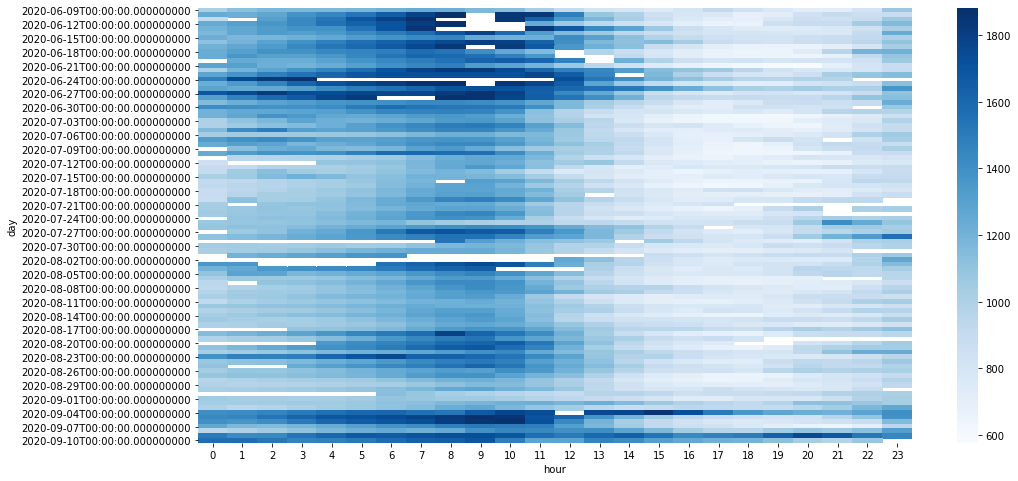

In [71]:
tab = get_table(data,10,param="co2",plot=True)

<div class="alert-block alert alert-danger">
    
The issue with generating these tables is that we seem to have irregular gaps in the dataset making any analysis that is affected by `NaN` tricky.

</div>

### Highest Scoring Relationship
Now that we have the results all summarized, we can see which relationships were the strongest per each beacon. Hopefully there is a trend...

In [ ]:
results_per_beacon = results_per_beacon[(results_per_beacon["param1"] != "no2") & (results_per_beacon["param2"] != "no2")]

In [ ]:
top_results_per_beacon = results_per_beacon[["beacon","mic"]].groupby("beacon").max().merge(right=results_per_beacon,on="mic").sort_values("mic",ascending=False)
top_results_per_beacon = top_results_per_beacon[top_results_per_beacon["mic"] > 0.5]

<div class="alert-block alert alert-warning">
    
This issue with these results is that too many of the MIC are equal to 1 for some beacons. This result is most likely caused by the large amount of data.

</div>

### Aggregating Daily MIC per Beacon
The idea is to calculate a MIC for each relationship on each beacon for each day and average them which might provide more appropriate results.

In [ ]:
def get_mic_per_beacon_by_day(df,params=["tvoc","co","co2","pm2p5_mass","temperature_c","rh"]):
    """gets the MIC score for each relationship in params for each beacon"""
    res = {"beacon":[],"param1":[],"param2":[],"mic":[]} # dict to store results
    for bb in df["beacon"].unique():
        print("Running for Beacon",bb,end="")
        s = datetime.now()
        data_by_beacon = get_beacon(df,bb).dropna()
        data_by_beacon = resample_data(data_by_beacon,5)
        data_by_beacon["date"] = data_by_beacon.index.date
        index = 1 # so we don't double-count relationships
        for p1 in params:
            for p2 in params[index:]:
                total_score = 0
                for d in data_by_beacon["date"].unique():
                    data_by_beacon_by_day = data_by_beacon[data_by_beacon["date"] == d]
                    total_score += get_mic(data_by_beacon_by_day,p1,p2)
                # appending results to dict
                for key, val in zip(res.keys(),[bb,p1,p2,total_score/len(data_by_beacon["date"].unique())]):
                    res[key].append(val)
                print(".",end="")

            index += 1
        e = datetime.now()
        print("\tTime to Complete:",get_timing(s,e))
            
    return pd.DataFrame(res)

In [ ]:
res = get_mic_per_beacon_by_day(data)

In [ ]:
res.sort_values("mic")

In [ ]:
b16

In [ ]:
b16 = get_beacon(data,16)
b16["date"] = b16.index.date
for d in b16["date"].unique()[:2]:
    fig, ax = plt.subplots()
    data_to_plot = b16[b16["date"] == d]
    print(data_to_plot)
    ax.scatter(data_to_plot["co"],data_to_plot["co2"])
    plt.show()
    plt.close()

<div class="alert-block alert alert-success">
    
Include one night from this participant as representative for _bad_ night to exclude.

</div>